<a href="https://colab.research.google.com/github/Adamoni22/UMWF/blob/main/UseCase2_AdamDownar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import danych
import pandas as pd
import seaborn as sns
import numpy as np
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [3]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [5]:
#Liczba filmów z kategorii Sci-Fi
liczba_filmow_scifi = movies[movies['genres'].str.contains('Sci-Fi')].shape[0]
print(liczba_filmow_scifi)

980


rating
4.0    0.272727
3.5    0.193182
3.0    0.136364
4.5    0.113636
2.5    0.068182
5.0    0.056818
2.0    0.056818
1.5    0.056818
1.0    0.022727
0.5    0.022727
Name: proportion, dtype: float64


<ipython-input-6-12d96695c390>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data = comedy_2017, palette='viridis')


<Axes: xlabel='rating', ylabel='count'>

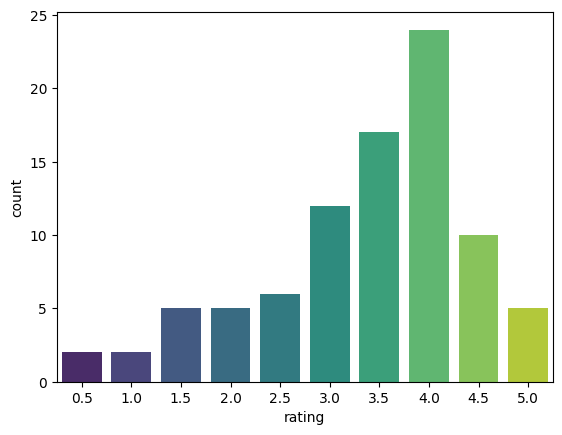

In [6]:
#rozkład ocen komedii
merged_data = pd.merge(movies, ratings, on='movieId')
comedy_2017 = merged_data[(merged_data['genres'].str.contains('Comedy')) & (merged_data['title'].str.contains('2017'))]
print(comedy_2017['rating'].value_counts(normalize=True))
sns.countplot(x='rating', data = comedy_2017, palette='viridis')

In [16]:
#Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy akcji najczęściej oceniane
action = merged_data[merged_data['genres'].str.contains('Action')]
mean_rating_action = action['rating'].mean().round(2)
top_3_action_movies= action['title'].value_counts()

In [17]:
print("Średnia ocena wszystkich filmów akcji z uwzględnieniem minimalnej liczby głosów : ", mean_rating_action)
print("Top 3 filmy akcji najczęsciej oceniane:")
print(top_3_action_movies)

Średnia ocena wszystkich filmów akcji z uwzględnieniem minimalnej liczby głosów :  3.45
Top 3 filmy akcji najczęsciej oceniane:
title
Matrix, The (1999)                                      278
Star Wars: Episode IV - A New Hope (1977)               251
Jurassic Park (1993)                                    238
Braveheart (1995)                                       237
Terminator 2: Judgment Day (1991)                       224
                                                       ... 
Sword of the Stranger (Sutorejia: Mukô hadan) (2007)      1
Gamers, The: Dorkness Rising (2008)                       1
Mesrine: Killer Instinct (L'instinct de mort) (2008)      1
Battle in Seattle (2007)                                  1
Bungo Stray Dogs: Dead Apple (2018)                       1
Name: count, Length: 1827, dtype: int64


System rekomendacji

In [20]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163008 sha256=0367b68ea0f2e976cc9489b31134876f4c90ad1ae940b37d9fe857e696ebd112
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [34]:
#Import bibliotek
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, KNNBaseline

In [22]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [23]:
trainset = data.build_full_trainset()
svd = SVD()
svd.fit(trainset)
cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8683  0.8744  0.8807  0.8714  0.8703  0.8730  0.0043  
MAE (testset)     0.6672  0.6691  0.6776  0.6697  0.6684  0.6704  0.0037  
Fit time          1.51    1.57    1.70    1.99    1.52    1.66    0.18    
Test time         0.38    0.12    0.21    0.14    0.13    0.20    0.10    


{'test_rmse': array([0.86826938, 0.87443897, 0.88066494, 0.87143259, 0.87028144]),
 'test_mae': array([0.66722358, 0.66906468, 0.6775847 , 0.66967915, 0.66837734]),
 'fit_time': (1.5067858695983887,
  1.5704231262207031,
  1.696106195449829,
  1.994321346282959,
  1.5193581581115723),
 'test_time': (0.38100361824035645,
  0.1212167739868164,
  0.20798420906066895,
  0.13860225677490234,
  0.12807011604309082)}

In [25]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}

param_grid = {
    'k': [2, 3, 4, 5, 6],
    'sim_options': {
        'name': ['cosine'],
        'user_based': [False]
    }
}

In [26]:
#Gridsearch dla knnbaseline
gs_knn = GridSearchCV(KNNBaseline, param_grid, measures=['RMSE', 'MAE'], cv=5)

gs_knn.fit(data)

print(gs_knn.best_score['rmse'])
print(gs_knn.best_params['rmse'])

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

In [27]:
#Trenowanie modelu KNNBaseline
best_knn = gs_knn.best_estimator['rmse']
trainset = data.build_full_trainset()
best_knn.fit(trainset)
cross_validate(best_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9622  0.9572  0.9437  0.9565  0.9613  0.9562  0.0066  
MAE (testset)     0.7438  0.7384  0.7258  0.7383  0.7401  0.7373  0.0061  
Fit time          8.47    8.39    8.36    7.66    8.50    8.28    0.31 

{'test_rmse': array([0.96215437, 0.95716369, 0.94371783, 0.95654782, 0.96133254]),
 'test_mae': array([0.74381489, 0.73841774, 0.7257723 , 0.738284  , 0.74010512]),
 'fit_time': (8.474825382232666,
  8.391847372055054,
  8.361633062362671,
  7.658313274383545,
  8.502069234848022),
 'test_time': (8.501377820968628,
  7.589883327484131,
  8.399882793426514,
  8.544373750686646,
  7.513359069824219)}

In [28]:
benchmark = []

for algorithm in [svd, best_knn]:
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    tmp = pd.DataFrame(results)
    numeric_columns = tmp.select_dtypes(include=[np.number]).columns
    mean_results = tmp[numeric_columns].mean(axis=0)  # Calculate mean only on numeric columns
    mean_results['Algorithm'] = str(algorithm).split(' ')[0].split('.')[-1]  # Add algorithm name as a new column
    benchmark.append(mean_results)
benchmark_df = pd.DataFrame(benchmark)
benchmark_df = benchmark_df.set_index('Algorithm').sort_values('test_rmse')
benchmark_df

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.873999,0.671941,1.782996,0.185528
KNNBaseline,0.953964,0.735374,10.380810,7.973935


In [ ]:
print(movies[movies['title'].str.contains('Penguins of Madagascar')])
print(movies[movies['title'].str.contains('Hobbit: The Desolation of Smaug')])

In [53]:
def find_recomended_movies(movie_id, num_similar=5):
    try:
        internal_id = best_knn.trainset.to_inner_iid(movie_id)
        similar_internal_ids = best_knn.get_neighbors(internal_id, k=num_similar)
        similar_movies = (best_knn.trainset.to_raw_iid(id) for id in similar_internal_ids)
        return list(similar_movies)
    except ValueError:
        print(f"Error: Movie ID {movie_id} nie istnieje.")
        return []

hobbit_id = 106489
penguin_id = 117851
recomended_hobbit_movies = find_recomended_movies(hobbit_id)
recomended_penguin_movies = find_recomended_movies(penguin_id)
print("recomendations for Hobbit: The Desolation of Smaug, The:   ",
      movies[movies['movieId'].isin(recomended_hobbit_movies)])
print("recomendations for Penguins of Madagascar:   ",
      movies[movies['movieId'].isin(recomended_penguin_movies)])

recomendations for Hobbit: The Desolation of Smaug, The:          movieId                                              title  \
1275     1690                         Alien: Resurrection (1997)   
2453     3266  Man Bites Dog (C'est arrivé près de chez vous)...   
2695     3616                                       Loser (2000)   
4549     6755                                Bubba Ho-tep (2002)   
7013    68205                         Crank: High Voltage (2009)   

                           genres  
1275         Action|Horror|Sci-Fi  
2453  Comedy|Crime|Drama|Thriller  
2695               Comedy|Romance  
4549                Comedy|Horror  
7013          Action|Comedy|Crime  
recomendations for Penguins of Madagascar:          movieId                                  title  \
0           1                       Toy Story (1995)   
2226     2959                      Fight Club (1999)   
2641     3535                 American Psycho (2000)   
4491     6643  Tokyo Story (Tôkyô monogatari)